# Plotting Few-Shot Model Evaluation Results

Assembling plots from summary files.

In [1]:
import os
import sys
import pandas as pd

# Setting up local details:
# This should be the location of the checkout of the FS-Mol repository:
FS_MOL_CHECKOUT_PATH = os.path.join(os.environ['HOME'], "FS-Mol-ADKT")
# This should be the location of the FS-Mol dataset:
FS_MOL_DATASET_PATH = os.path.join(os.environ['HOME'], "fs-mol-dataset")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

from fs_mol.plotting.utils import (
    highlight_max_all, 
    plot_all_assays, 
    load_data,
    expand_values,
    plot_task_performances_by_id,
    box_plot,
    plot_by_size,
    get_aggregates_across_sizes,
    walltime_plot
)

## Making summary files

Summary files are obtained by running `fs_mol/plotting/collect_eval_runs.py` on the outputs of evaluation runs. If an evaluation output directory is "evaluation_output_directory" then summary files are created with: 

The option `--plot` results in a plot across support set sizes for each few-shot testing task. Final summarized results will be found in "evaluation_output_directory/summary/{model_name}_summary.csv"

## Loading the collated evaluation data

Create a dictionary of all model summary .csvs to be compared. The csvs are the final summaries from `collect_eval_runs.py`

In [2]:
# Configure this to contain all the models that you want to look at.
# Dict keys are human readable names, values are the path to the summary produced by collect_eval_runs.py
results_path = os.path.join(FS_MOL_CHECKOUT_PATH, "baselines")
output_path = os.path.join(FS_MOL_CHECKOUT_PATH, "visualize_results")

# a dictionary summarising all models to be compared. Add new paths here as desired.
model_summaries = {
    "ADKF-IFT": os.path.join(output_path, "ADKF-IFT/ADKF-IFT_classification_summary.csv"),
    "ADKF": os.path.join(output_path, "ablation_models/ADKF_classification_summary.csv"),
    "DKT$+$": os.path.join(output_path, "ablation_models/DKT-plus_classification_summary.csv"),
    "DKT": os.path.join(output_path, "DKT/DKT_classification_summary.csv"),
}
# Generated plots will be stored here, if you want to keep them. None disables saving.
plot_output_dir = os.path.join(output_path, "plots/classification_ablation")
all_tasks_output_dir = os.path.join(plot_output_dir, "all_tasks")
os.makedirs(plot_output_dir, exist_ok=True)
os.makedirs(all_tasks_output_dir, exist_ok=True)

In [3]:
data = load_data(model_summaries)

Loading data for ADKF-IFT from /homes/wc337/FS-Mol-ADKT/visualize_results/ADKF-IFT/ADKF-IFT_classification_summary.csv.
Loading data for ADKF from /homes/wc337/FS-Mol-ADKT/visualize_results/ablation_models/ADKF_classification_summary.csv.
Loading data for DKT$+$ from /homes/wc337/FS-Mol-ADKT/visualize_results/ablation_models/DKT-plus_classification_summary.csv.
Loading data for DKT from /homes/wc337/FS-Mol-ADKT/visualize_results/DKT/DKT_classification_summary.csv.


## Highlight the best result for each task

In [4]:
styled_df = data.style.apply(lambda row: highlight_max_all(row), axis=1)
# To save for exporting purposes, uncomment this (requires `pip install xlsxwriter`)
styled_df.to_excel(os.path.join(plot_output_dir, f"highlighted_comparison.xlsx"), engine='xlsxwriter')

styled_df

,TASK_ID,fraction_positive_train,fraction_positive_test,16_train (ADKF-IFT),32_train (ADKF-IFT),64_train (ADKF-IFT),128_train (ADKF-IFT),256_train (ADKF-IFT),16_train (ADKF),32_train (ADKF),64_train (ADKF),128_train (ADKF),256_train (ADKF),16_train (DKT$+$),32_train (DKT$+$),64_train (DKT$+$),128_train (DKT$+$),256_train (DKT$+$),16_train (DKT),32_train (DKT),64_train (DKT),128_train (DKT),256_train (DKT)
0,1006005,0.494141,0.492253,0.578+/-0.048,0.594+/-0.049,0.605+/-0.033,0.618+/-0.088,nan,0.597+/-0.07,0.611+/-0.059,0.623+/-0.036,0.626+/-0.076,nan,0.579+/-0.052,0.604+/-0.059,0.613+/-0.022,0.619+/-0.065,nan,0.58+/-0.053,0.605+/-0.059,0.618+/-0.022,0.633+/-0.062,nan
1,1066254,0.494141,0.482321,0.683+/-0.066,0.757+/-0.051,0.835+/-0.04,0.865+/-0.072,nan,0.703+/-0.06,0.777+/-0.053,0.847+/-0.044,0.869+/-0.086,nan,0.676+/-0.057,0.754+/-0.072,0.824+/-0.04,0.873+/-0.092,nan,0.674+/-0.056,0.753+/-0.071,0.821+/-0.042,0.869+/-0.094,nan
2,1119333,0.500000,0.498240,0.784+/-0.038,0.79+/-0.028,0.824+/-0.022,0.857+/-0.035,0.899+/-0.025,0.783+/-0.042,0.789+/-0.03,0.825+/-0.027,0.863+/-0.031,0.906+/-0.022,0.773+/-0.041,0.769+/-0.04,0.804+/-0.031,0.843+/-0.038,0.878+/-0.027,0.773+/-0.04,0.769+/-0.041,0.805+/-0.03,0.845+/-0.038,0.879+/-0.025
3,1243967,0.500000,0.500000,0.832+/-0.037,0.852+/-0.035,0.863+/-0.024,0.895+/-0.018,nan,0.78+/-0.068,0.808+/-0.057,0.84+/-0.015,0.879+/-0.019,nan,0.838+/-0.026,0.844+/-0.043,0.863+/-0.016,0.889+/-0.019,nan,0.84+/-0.025,0.848+/-0.04,0.864+/-0.016,0.889+/-0.021,nan
4,1243970,0.500000,0.500000,0.804+/-0.06,0.826+/-0.027,0.854+/-0.03,0.875+/-0.024,nan,0.758+/-0.068,0.791+/-0.034,0.833+/-0.037,0.853+/-0.027,nan,0.79+/-0.058,0.816+/-0.037,0.841+/-0.039,0.861+/-0.025,nan,0.791+/-0.057,0.817+/-0.037,0.843+/-0.041,0.862+/-0.027,nan
5,1613777,0.496875,0.492447,0.524+/-0.043,0.554+/-0.027,0.586+/-0.038,0.618+/-0.03,0.65+/-0.011,0.531+/-0.052,0.566+/-0.034,0.597+/-0.042,0.627+/-0.034,0.66+/-0.016,0.527+/-0.044,0.543+/-0.027,0.575+/-0.029,0.607+/-0.026,0.632+/-0.015,0.528+/-0.044,0.544+/-0.026,0.577+/-0.028,0.61+/-0.026,0.636+/-0.014
6,1613800,0.393750,0.396898,0.456+/-0.021,0.463+/-0.034,0.484+/-0.02,0.5+/-0.023,0.537+/-0.009,0.453+/-0.024,0.458+/-0.025,0.481+/-0.015,0.502+/-0.02,0.542+/-0.01,0.453+/-0.027,0.454+/-0.028,0.475+/-0.02,0.496+/-0.012,0.529+/-0.014,0.452+/-0.027,0.452+/-0.028,0.471+/-0.02,0.49+/-0.011,0.52+/-0.014
7,1613898,0.500000,0.493828,0.57+/-0.044,0.585+/-0.032,0.602+/-0.03,0.631+/-0.056,nan,0.58+/-0.043,0.597+/-0.036,0.633+/-0.045,0.678+/-0.053,nan,0.574+/-0.035,0.628+/-0.055,0.643+/-0.046,0.667+/-0.063,nan,0.574+/-0.035,0.628+/-0.056,0.637+/-0.041,0.653+/-0.065,nan
8,1613907,0.494141,0.486552,0.603+/-0.053,0.636+/-0.041,0.648+/-0.038,0.655+/-0.098,nan,0.602+/-0.043,0.644+/-0.039,0.66+/-0.042,0.659+/-0.08,nan,0.615+/-0.036,0.628+/-0.054,0.656+/-0.035,0.682+/-0.068,nan,0.612+/-0.036,0.63+/-0.054,0.664+/-0.035,0.688+/-0.075,nan
9,1613926,0.500000,0.478118,0.653+/-0.065,0.699+/-0.069,0.738+/-0.034,0.834+/-0.175,nan,0.655+/-0.069,0.697+/-0.062,0.74+/-0.038,0.854+/-0.182,nan,0.646+/-0.081,0.694+/-0.059,0.735+/-0.032,0.795+/-0.185,nan,0.646+/-0.081,0.693+/-0.056,0.735+/-0.03,0.795+/-0.185,nan


In [5]:
# expand out from val +/- error format, and calculate delta AUPRC
data = expand_values(data, model_summaries)

## Performance Overview over all Tasks

This compares with the trivial baseline of using a weighted coinflip according to the class imbalance in the training data.

In [6]:
# This uses Latex to render plots, and requires the type1ec and type1cm packages.
# It also required the dvipng utility.
# On Debian/Ubuntu-based systems, this can be installed using `apt install cm-super texlive-latex-extra dvipng`

#plot_task_performances_by_id(data, model_summaries, support_set_size = 16)

### Incorporate protein information

Our test tasks have associated target protein information available. We can merge this data to allow plotting with specific EC number classes highlighted.

In [7]:
protein_path = os.path.join(FS_MOL_CHECKOUT_PATH, "datasets/targets", "test_proteins.csv")
ecs = pd.read_csv(protein_path)
ecs["target_id"] = ecs["target_id"].astype(int).astype(str)
ecs["chembl_id"] = ecs["chembl_id"].astype(str)
ecs["TASK_ID"] = ecs.apply(lambda row: row["chembl_id"][6:], axis = 1)

data = ecs.merge(data, on="TASK_ID")

In [8]:
# the highlight class is the EC class that will be highlighted in the resulting plot. 
# You may wish to use this for comparison across different EC classes.
# plot_task_performances_by_id(data, model_summaries, support_set_size = 16, highlight_class = 2)

## Plot for each task, comparing different models

This makes an individual comparison plot over models for each few-shot testing task, across all support set sizes available. 

**Warning** Not to use lightly, it will take a few minutes to complete

In [9]:
# plot_all_assays(data, model_summaries.keys(), results_dir = all_tasks_output_dir)

# Summarise the overall performance in box plots

This reproduces the model comparison box plots in the manuscript.

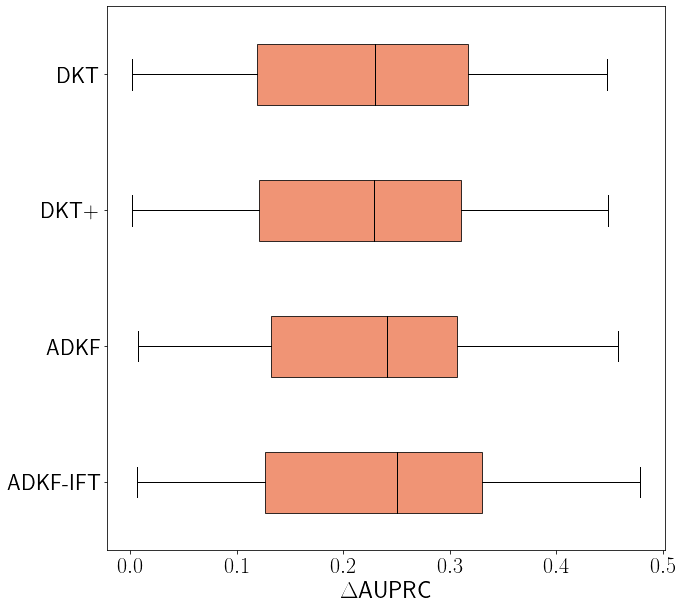

In [10]:
box_plot(data, model_summaries, support_set_size = 16, plot_output_dir=plot_output_dir)

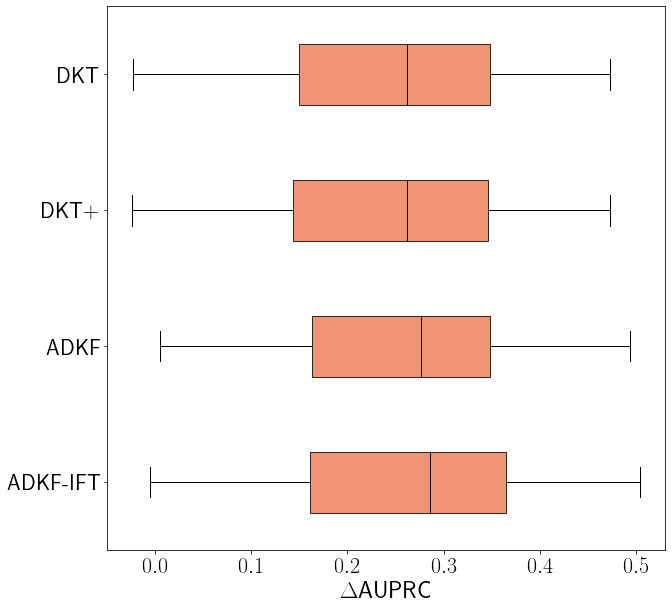

In [11]:
box_plot(data, model_summaries, support_set_size = 32, plot_output_dir=plot_output_dir)

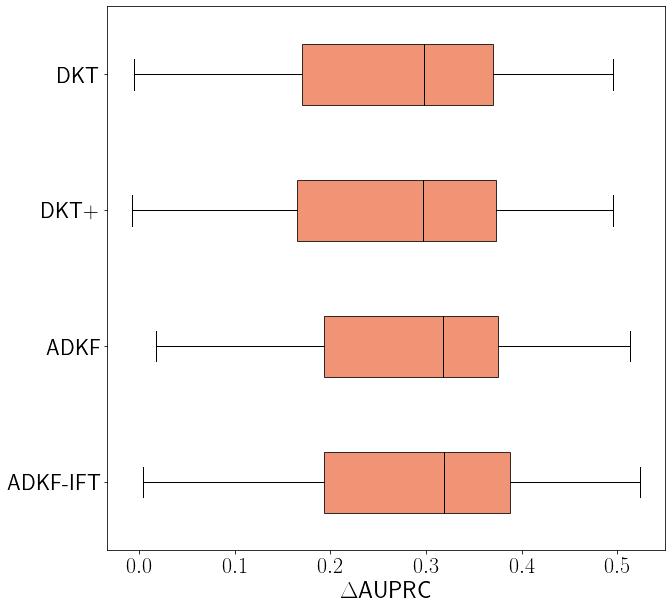

In [12]:
box_plot(data, model_summaries, support_set_size = 64, plot_output_dir=plot_output_dir)

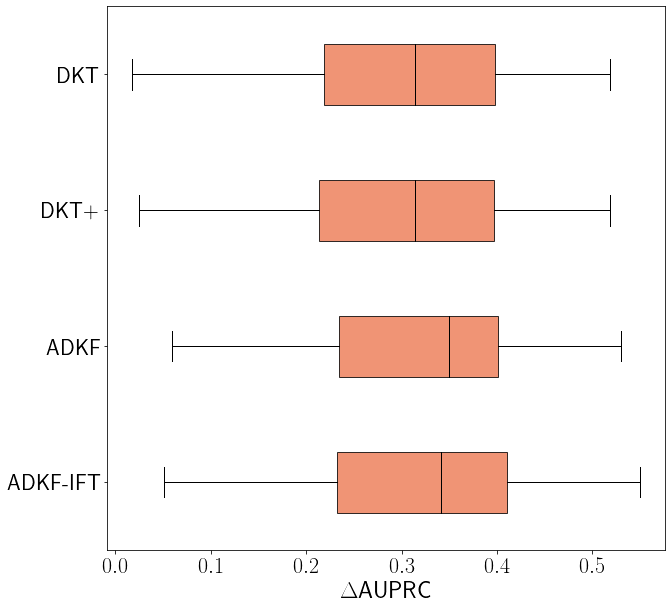

In [13]:
box_plot(data, model_summaries, support_set_size = 128, plot_output_dir=plot_output_dir)

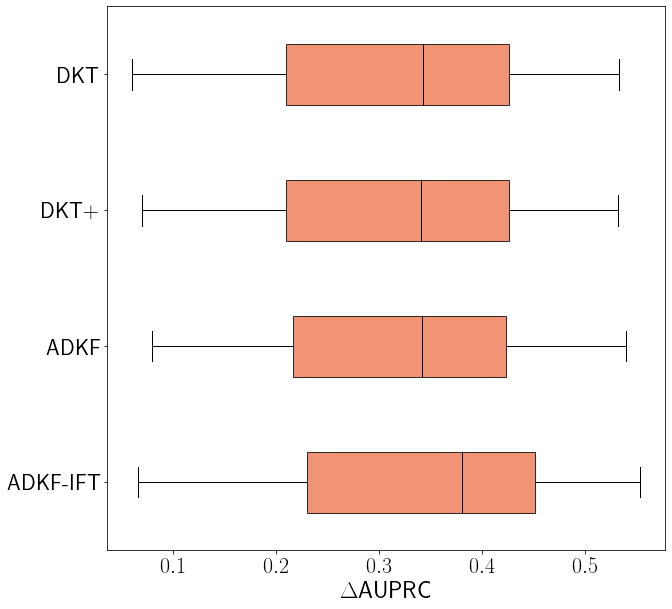

In [14]:
box_plot(data, model_summaries, support_set_size = 256, plot_output_dir=plot_output_dir)

## Aggregate as a function of the number of training points, across all categories

Here the results are aggregated according to EC class, and across all classes. This is used to plot the variation of performance with support set size, comparing all models in the model_summaries dictionary. 

In [15]:
aggregate_df = get_aggregates_across_sizes(data, model_summaries)

In [16]:
# show results of Table 2 for support set size 16
cols = [x for x  in aggregate_df.columns if x.startswith("16")]
aggregate_df[cols]

,16_train (ADKF-IFT),16_train (ADKF),16_train (DKT$+$),16_train (DKT),16_train (ADKF-IFT) std,16_train (ADKF) std,16_train (DKT$+$) std,16_train (DKT) std
EC_category,,,,,,,,
3,0.214107,0.203907,0.200857,0.201607,0.029099,0.027270,0.031148,0.031225
2,0.244256,0.235560,0.227080,0.228152,0.010015,0.009575,0.009762,0.009753
1,0.104971,0.109400,0.100828,0.101542,0.036305,0.035918,0.032081,0.032732
4,0.225000,0.208000,0.233500,0.231000,0.160000,0.121000,0.196500,0.198000
5,0.123000,0.130000,0.103000,0.102000,0.049000,0.040000,0.040000,0.039000
7,0.083859,0.102859,0.084859,0.085859,0.048000,0.070000,0.052000,0.053000
6,0.105000,0.114000,0.123000,0.121000,0.066000,0.062000,0.060000,0.062000
all,0.231279,0.223260,0.215833,0.216769,0.009415,0.008900,0.009300,0.009308


In [17]:
cols = [x for x  in aggregate_df.columns if x.startswith("32")]
aggregate_df[cols]

,32_train (ADKF-IFT),32_train (ADKF),32_train (DKT$+$),32_train (DKT),32_train (ADKF-IFT) std,32_train (ADKF) std,32_train (DKT$+$) std,32_train (DKT) std
EC_category,,,,,,,,
3,0.234157,0.227607,0.223857,0.224907,0.030643,0.029319,0.031747,0.031775
2,0.277024,0.270664,0.258104,0.259384,0.009944,0.009565,0.009703,0.009641
1,0.138114,0.140400,0.123542,0.123257,0.042288,0.039855,0.036617,0.036804
4,0.252500,0.253500,0.253000,0.249000,0.195500,0.163500,0.212000,0.215000
5,0.157000,0.163000,0.144000,0.146000,0.047000,0.041000,0.044000,0.044000
7,0.099859,0.116859,0.109859,0.110859,0.049000,0.059000,0.059000,0.059000
6,0.188000,0.193000,0.193000,0.193000,0.036000,0.037000,0.037000,0.037000
all,0.262597,0.256992,0.245591,0.246699,0.009553,0.009111,0.009377,0.009351


In [18]:
cols = [x for x  in aggregate_df.columns if x.startswith("64")]
aggregate_df[cols]

,64_train (ADKF-IFT),64_train (ADKF),64_train (DKT$+$),64_train (DKT),64_train (ADKF-IFT) std,64_train (ADKF) std,64_train (DKT$+$) std,64_train (DKT) std
EC_category,,,,,,,,
3,0.263707,0.260357,0.254907,0.255607,0.032685,0.032251,0.033932,0.033762
2,0.300368,0.296592,0.282568,0.283928,0.010006,0.009486,0.009894,0.009749
1,0.162400,0.167114,0.149542,0.147257,0.044826,0.043396,0.040390,0.040514
4,0.281000,0.316000,0.280500,0.274500,0.201000,0.162000,0.200500,0.205500
5,0.200000,0.216000,0.204000,0.206000,0.046000,0.046000,0.056000,0.058000
7,0.110859,0.128859,0.118859,0.123859,0.033000,0.036000,0.022000,0.022000
6,0.233000,0.238000,0.233000,0.231000,0.022000,0.023000,0.015000,0.013000
all,0.287024,0.284495,0.271228,0.272253,0.009704,0.009217,0.009602,0.009520


In [19]:
cols = [x for x  in aggregate_df.columns if x.startswith("128")]
aggregate_df[cols]

,128_train (ADKF-IFT),128_train (ADKF),128_train (DKT$+$),128_train (DKT),128_train (ADKF-IFT) std,128_train (ADKF) std,128_train (DKT$+$) std,128_train (DKT) std
EC_category,,,,,,,,
3,0.296507,0.296007,0.283457,0.282857,0.033039,0.032881,0.034472,0.034503
2,0.331400,0.329832,0.314824,0.315920,0.009718,0.009290,0.009742,0.009567
1,0.192400,0.202542,0.179971,0.176257,0.043236,0.043152,0.039513,0.040472
4,0.291500,0.340000,0.306000,0.302500,0.192500,0.145000,0.184000,0.187500
5,0.241000,0.264000,0.248000,0.251000,0.031000,0.034000,0.028000,0.034000
7,0.123859,0.131859,0.124859,0.138859,0.088000,0.076000,0.065000,0.062000
6,0.271000,0.273000,0.268000,0.267000,0.031000,0.029000,0.033000,0.032000
all,0.317967,0.317935,0.302769,0.303457,0.009522,0.009104,0.009527,0.009440


In [20]:
cols = [x for x  in aggregate_df.columns if x.startswith("256")]
aggregate_df[cols]

,256_train (ADKF-IFT),256_train (ADKF),256_train (DKT$+$),256_train (DKT),256_train (ADKF-IFT) std,256_train (ADKF) std,256_train (DKT$+$) std,256_train (DKT) std
EC_category,,,,,,,,
3,0.259397,0.257826,0.241112,0.239254,0.049421,0.052232,0.052190,0.052863
2,0.376261,0.360551,0.356745,0.356100,0.022779,0.021573,0.021559,0.021918
1,0.159344,0.165094,0.146844,0.144344,0.023642,0.023890,0.024813,0.027108
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0.313000,0.309000,0.310000,0.310000,0.018000,0.018000,0.021000,0.021000
all,0.335587,0.324448,0.317308,0.316308,0.021159,0.020071,0.020503,0.020808


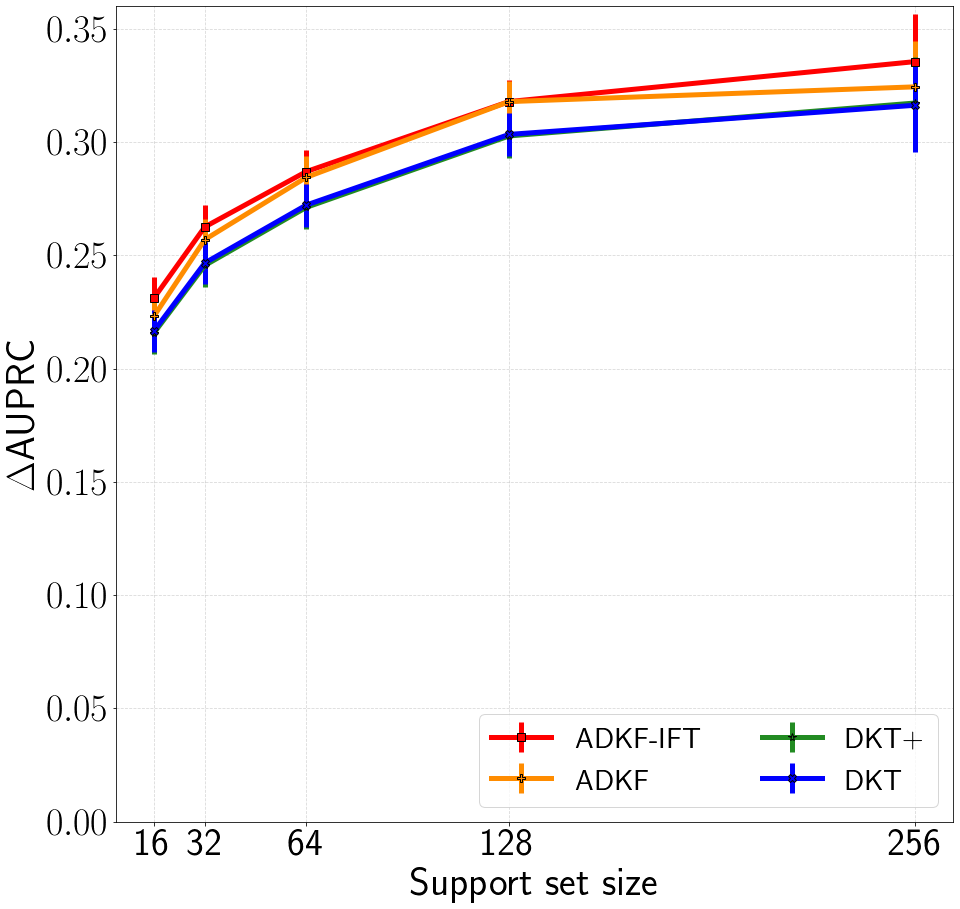

In [21]:
# this function has the option to plot all classes separately.
plot_by_size(aggregate_df, model_summaries, plot_output_dir = plot_output_dir)

# Ranking

Here we use [autorank](https://pypi.org/project/autorank/) for an appropriate comparison between all methods when evaluated on multiple tasks.


In [22]:
from autorank import autorank

# select correct data to rank with autorank
for size in [16, 32, 64, 128, 256]:

    df = data[[x for x in list(data.columns) if x.startswith(f"{size}") and "val" in x and "delta-auprc" in x]]
    result = autorank(df, verbose=False)
    print(result.rankdf["meanrank"])
    print()

16_train (DKT$+$) val delta-auprc      2.974522
16_train (DKT) val delta-auprc         2.757962
16_train (ADKF) val delta-auprc        2.283439
16_train (ADKF-IFT) val delta-auprc    1.984076
Name: meanrank, dtype: float64

32_train (DKT$+$) val delta-auprc      3.060510
32_train (DKT) val delta-auprc         2.888535
32_train (ADKF) val delta-auprc        2.143312
32_train (ADKF-IFT) val delta-auprc    1.907643
Name: meanrank, dtype: float64

64_train (DKT$+$) val delta-auprc      3.038217
64_train (DKT) val delta-auprc         2.834395
64_train (ADKF) val delta-auprc        2.095541
64_train (ADKF-IFT) val delta-auprc    2.031847
Name: meanrank, dtype: float64

128_train (DKT$+$) val delta-auprc      2.958599
128_train (DKT) val delta-auprc         2.824841
128_train (ADKF-IFT) val delta-auprc    2.165605
128_train (ADKF) val delta-auprc        2.050955
Name: meanrank, dtype: float64

256_train (DKT$+$) val delta-auprc      3.127907
256_train (DKT) val delta-auprc         3.058140
25

In [23]:
from fs_mol.plotting.utils import collect_model_results
import matplotlib.pyplot as plt
import numpy as np

TRAIN_SIZES_TO_COMPARE = [16, 32, 64, 128, 256]
color_set = ["red", "darkorange", "forestgreen", "blue", "darkviolet", "slategrey", "black", "olive", "plum", "yellow", "teal", "lightgreen"]

In [24]:
vals, stds = collect_model_results(aggregate_df, model_summaries)
categories = {x: i for i, x in enumerate(vals["ADKF-IFT"].index)}
reduced_list = ["all"]
highlight_class = "all"
reduced = {k: categories[k] for k in reduced_list if k in categories}
plot_dict = reduced

In [25]:
plt.rcParams.update(
    {
        "font.size": 26,
        "text.usetex": True,
        #"font.family": "serif",
        #"font.serif": "Computer Modern Roman",
    }
)

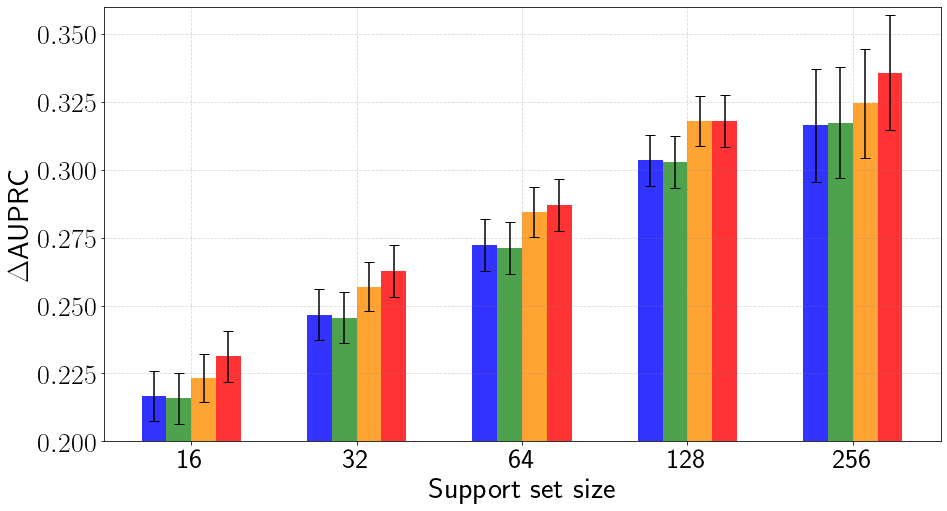

In [26]:
fig, ax = plt.subplots(figsize=(15, 8))

x_pos = np.arange(len(TRAIN_SIZES_TO_COMPARE))
offset = [-0.225, -0.075, 0.075, 0.225]
marker_set = [".", "v", "P", "*"]

num_tasks = 157

for j, model_name in enumerate(model_summaries.keys()):

    a = vals[model_name]
    v = stds[model_name]

    for cls, i in plot_dict.items():
        
        ax.bar(
            x_pos-offset[j],
            a.values[i],
            0.15,
            yerr=v.values[i],
            ecolor='black',
            capsize=5,
            label=model_name,
            color=color_set[j],
            alpha=0.8,
        )
#         ax.errorbar(
#             x_pos-offset[j],
#             a.values[i],
#             markersize=20,
#             yerr=v.values[i],
#             label=model_name,
#             c=color_set[j],
#             fmt=marker_set[j],
#             lw=5
#         )

#ax.legend(loc="upper left", fontsize=28)
ax.set_ylabel("$\Delta$AUPRC", fontsize=30)
ax.set_xlabel("Support set size", fontsize=30)
ax.set_xticks(x_pos, TRAIN_SIZES_TO_COMPARE, fontsize=28)
ax.set_xticklabels(TRAIN_SIZES_TO_COMPARE, fontsize=28)
ax.tick_params(axis='y', labelsize=28)
ax.set_ylim([0.20, 0.36])
plt.grid(True, color="grey", alpha=0.3, linestyle="--")

if plot_output_dir is not None:
    plt.savefig(
        os.path.join(plot_output_dir, f"comparison_plot_hc_{highlight_class}_ablation.pdf"),
        bbox_inches="tight",
    )

# need to do this to get autorank to work (does not work by setting in notebook)
plt.rcParams.update(
    {
        "text.usetex": False,
    }
)

plt.show(fig)
plt.close(fig)

In [27]:
from scipy.stats import wilcoxon

# select correct data to rank with autorank
for size in [16, 32, 64, 128, 256]:

    df = data[[x for x in list(data.columns) if (x.startswith(f"{size}_train (ADKF-IFT)") or x.startswith(f"{size}_train (DKT$+$)")) and "val" in x and "delta-auprc" in x]]
    df = df.dropna()
    diff = df.iloc[:,1] - df.iloc[:,0]
    diff = diff.to_numpy()
    print("number of tasks:", len(df))
    print("wilcoxon (two-sided):", wilcoxon(diff).pvalue)
    #print(create_report(result))
    print()

number of tasks: 157
wilcoxon (two-sided): 3.15309706471213e-13

number of tasks: 157
wilcoxon (two-sided): 6.963149185396527e-15

number of tasks: 157
wilcoxon (two-sided): 2.3302596063358005e-13

number of tasks: 157
wilcoxon (two-sided): 1.1758214844483262e-09

number of tasks: 43
wilcoxon (two-sided): 1.628687484497968e-06



In [28]:
from scipy.stats import wilcoxon

# select correct data to rank with autorank
for size in [16, 32, 64, 128, 256]:

    df = data[[x for x in list(data.columns) if (x.startswith(f"{size}_train (ADKF-IFT)") or x.startswith(f"{size}_train (ADKF)")) and "val" in x and "delta-auprc" in x]]
    df = df.dropna()
    diff = df.iloc[:,1] - df.iloc[:,0]
    diff = diff.to_numpy()
    print("number of tasks:", len(df))
    print("wilcoxon (two-sided):", wilcoxon(diff).pvalue)
    #print(create_report(result))
    print()

number of tasks: 157
wilcoxon (two-sided): 0.017496598128081627

number of tasks: 157
wilcoxon (two-sided): 0.10909831149524624

number of tasks: 157
wilcoxon (two-sided): 0.48177036122419215

number of tasks: 157
wilcoxon (two-sided): 0.8262532434234855

number of tasks: 43
wilcoxon (two-sided): 0.0015641889573997918

